1. Import dependencies and data


In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
from matplotlib import pyplot as plt
import numpy as np

In [ ]:
# Use the tensorflow datasets api to bring in the data source
ds = tfds.load('mnist', split='train')

Dl Completed...:   0%|          | 0/5 [00:00<?, ? file/s]

Dataset mnist downloaded and prepared to /root/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.


In [ ]:
# Scale and return images only
def scale_images(data):
    image = data['image']
    return image / 255

In [ ]:
# Load the dataset
ds = tfds.load('mnist', split='train')
# Running the dataset through the scale_images preprocessing step
ds = ds.map(scale_images)
# Cache the dataset for that batch
ds = ds.cache()
# Shuffle it up
ds = ds.shuffle(60000)
# Batch into 128 images per sample
ds = ds.batch(128)
# Reduces the likelihood of bottlenecking
ds = ds.prefetch(64)

2. Build Neural Network

2.1 Import Modelling Components

In [ ]:
# Bring in the sequential api for the generator and discriminator
from tensorflow.keras.models import Sequential
# Bring in the layers for the neural network
from tensorflow.keras.layers import Conv2D, Dense, Flatten, Reshape, LeakyReLU, Dropout, UpSampling2D

2.2 Build Generator

In [ ]:
def build_generator():
    model = Sequential()

    # Takes in random values and reshapes it to 7x7x128
    # Beginnings of a generated image
    model.add(Dense(7*7*128, input_dim=100))
    model.add(LeakyReLU(0.2))
    model.add(Reshape((7,7,128)))

    # Upsampling block 1
    model.add(UpSampling2D())
    model.add(Conv2D(128, 5, padding='same'))
    model.add(LeakyReLU(0.2))

    # Upsampling block 2
    model.add(UpSampling2D())
    model.add(Conv2D(128, 5, padding='same'))
    model.add(LeakyReLU(0.2))

    # Convolutional block 1
    model.add(Conv2D(128, 4, padding='same'))
    model.add(LeakyReLU(0.2))

    # Convolutional block 2
    model.add(Conv2D(128, 4, padding='same'))
    model.add(LeakyReLU(0.2))

    # Conv layer to get to one channel
    model.add(Conv2D(1, 4, padding='same', activation='sigmoid'))

    return model

In [ ]:
generator = build_generator()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
generator.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 6272)                │         633,472 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu (LeakyReLU)              │ (None, 6272)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 7, 7, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d (UpSampling2D)         │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 14, 14, 128)         │         409,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_1 (LeakyReLU)            │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_1 (UpSampling2D)       │ (None, 28, 28, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 28, 28, 128)         │         409,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_2 (LeakyReLU)            │ (None, 28, 28, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 28, 28, 128)         │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_3 (LeakyReLU)            │ (None, 28, 28, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 28, 28, 128)         │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_4 (LeakyReLU)            │ (None, 28, 28, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 28, 28, 1)           │           2,049 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,979,521 (7.55 MB)

 Trainable params: 1,979,521 (7.55 MB)

 Non-trainable params: 0 (0.00 B)

2.3 Build Discriminator

In [ ]:
def build_discriminator():
    model = Sequential()

    # First Conv Block
    model.add(Conv2D(32, 5, input_shape = (28,28,1)))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))

    # Second Conv Block
    model.add(Conv2D(64, 5))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))

    # Third Conv Block
    model.add(Conv2D(128, 5))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))

    # Fourth Conv Block
    model.add(Conv2D(256, 5))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))

    # Flatten then pass to dense layer
    model.add(Flatten())
    model.add(Dropout(0.4))
    model.add(Dense(1, activation='sigmoid'))

    return model

In [ ]:
discriminator = build_discriminator()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
discriminator.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_5 (Conv2D)                    │ (None, 24, 24, 32)          │             832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_5 (LeakyReLU)            │ (None, 24, 24, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 24, 24, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 20, 20, 64)          │          51,264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_6 (LeakyReLU)            │ (None, 20, 20, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 20, 20, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 16, 16, 128)         │         204,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_7 (LeakyReLU)            │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 12, 12, 256)         │         819,456 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_8 (LeakyReLU)            │ (None, 12, 12, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 12, 12, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 36864)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 36864)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │          36,865 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,113,345 (4.25 MB)

 Trainable params: 1,113,345 (4.25 MB)

 Non-trainable params: 0 (0.00 B)

3. Construct Training Loop

3.1 Setup Losses and Optimizers

In [ ]:
# Adam is going to be the optimizer for both
from tensorflow.keras.optimizers import Adam
# Binary cross entropy is going to be the loss for both
from tensorflow.keras.losses import BinaryCrossentropy

In [ ]:
g_opt = Adam(learning_rate=0.0001)
d_opt = Adam(learning_rate=0.0001)
g_loss = BinaryCrossentropy()
d_loss = BinaryCrossentropy()

3.2 Build Subclassed Model

In [ ]:
# Importing the base model class to subclass our training step
from tensorflow.keras.models import Model

In [ ]:
class HandwrittenGAN(Model):
    def __init__(self, generator, discriminator, *args, **kwargs):
        # Pass through args and kwargs to base class
        super().__init__(*args, **kwargs)

        # Create attributes for gen and disc
        self.generator = generator
        self.discriminator = discriminator

    def compile(self, g_opt, d_opt, g_loss, d_loss, *args, **kwargs):
        # Compile with base class
        super().compile(*args, **kwargs)

        # Create attributes for losses and optimizers
        self.g_opt = g_opt
        self.d_opt = d_opt
        self.g_loss = g_loss
        self.d_loss = d_loss

    def train_step(self, batch):
        # Get the data
        real_images = batch
        fake_images = self.generator(tf.random.normal((128, 100, 1)), training=False)

        # Train the discriminator
        with tf.GradientTape() as d_tape:
            # Pass the real and fake images to the discriminator model
            yhat_real = self.discriminator(real_images, training=True)
            yhat_fake = self.discriminator(fake_images, training=True)
            yhat_realfake = tf.concat([yhat_real, yhat_fake], axis=0)

            # Create labels for real and fakes images
            y_realfake = tf.concat([tf.zeros_like(yhat_real), tf.ones_like(yhat_fake)], axis=0)

            # Add some noise to the TRUE outputs
            noise_real = 0.05*tf.random.uniform(tf.shape(yhat_real))
            noise_fake = -0.05*tf.random.uniform(tf.shape(yhat_fake))
            y_realfake += tf.concat([noise_real, noise_fake], axis=0)

            # Calculate loss - BINARYCROSS
            total_d_loss = self.d_loss(y_realfake, yhat_realfake)

        # Apply backpropagation - nn learn
        dgrad = d_tape.gradient(total_d_loss, self.discriminator.trainable_variables)
        self.d_opt.apply_gradients(zip(dgrad, self.discriminator.trainable_variables))

        # Train the generator
        with tf.GradientTape() as g_tape:
            # Generate some new images
            gen_images = self.generator(tf.random.normal((128,100,1)), training=True)

            # Create the predicted labels
            predicted_labels = self.discriminator(gen_images, training=False)

            # Calculate loss - trick to training to fake out the discriminator
            total_g_loss = self.g_loss(tf.zeros_like(predicted_labels), predicted_labels)

        # Apply backprop
        ggrad = g_tape.gradient(total_g_loss, self.generator.trainable_variables)
        self.g_opt.apply_gradients(zip(ggrad, self.generator.trainable_variables))

        return {"d_loss":total_d_loss, "g_loss":total_g_loss}


In [ ]:
# Create instance of subclassed model
handwrittengan = HandwrittenGAN(generator, discriminator)

In [ ]:
# Compile the model
handwrittengan.compile(g_opt, d_opt, g_loss, d_loss)

3.3 Build Callback

In [ ]:
import os
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.callbacks import Callback

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Create a folder in the root directory
!mkdir -p "/content/drive/My Drive/images_epoch100"

Mounted at /content/drive


In [ ]:
class ModelMonitor(Callback):
    def __init__(self, num_img=1, latent_dim=100, freq=50):
        self.num_img = num_img
        self.latent_dim = latent_dim
        self.freq = freq

    def on_epoch_end(self, epoch, logs=None):
        # Save one generated image in each epoch
        random_latent_vectors = tf.random.uniform((self.num_img, self.latent_dim,1))
        generated_images = self.model.generator(random_latent_vectors)
        generated_images *= 255
        generated_images.numpy()
        for i in range(self.num_img):
            img = array_to_img(generated_images[i])
            img.save(os.path.join('/content/drive/My Drive/images_epoch100', f'generated_img_{epoch}.png'))

        #Save weights per freq epochs
        if epoch > 0 and epoch % self.freq == 0:
            generator.save(os.path.join('/content/drive/My Drive/images_epoch100',f'generator_{epoch}.h5'))

3.4 Train

In [ ]:
hist = handwrittengan.fit(ds, epochs=100, callbacks=[ModelMonitor()])

#Save weights
generator.save('/content/drive/My Drive/generator.h5')
discriminator.save('/content/drive/My Drive/discriminator.h5')

Epoch 1/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 72s 100ms/step - d_loss: 0.1638 - g_loss: 3.3141
Epoch 2/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 36s 78ms/step - d_loss: 0.4478 - g_loss: 2.1717
Epoch 3/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 37s 78ms/step - d_loss: 0.5237 - g_loss: 1.2622
Epoch 4/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 36s 78ms/step - d_loss: 0.6080 - g_loss: 0.9609
Epoch 5/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 37s 78ms/step - d_loss: 0.6134 - g_loss: 0.8226
Epoch 6/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 37s 78ms/step - d_loss: 0.6003 - g_loss: 0.8780
Epoch 7/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 37s 78ms/step - d_loss: 0.6085 - g_loss: 0.8715
Epoch 8/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 37s 78ms/step - d_loss: 0.6120 - g_loss: 0.8505
Epoch 9/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 37s 78ms/step - d_loss: 0.5962 - g_loss: 0.8709
Epoch 10/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 37s 78ms/step - d_loss: 0.6060 - g_loss: 0.8441
Epoch 11/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 37s 78ms/step - d_loss: 0.6121 - g_loss: 0.8516
Epoch 12/100
469/4

469/469 ━━━━━━━━━━━━━━━━━━━━ 37s 78ms/step - d_loss: 0.6881 - g_loss: 0.7274
Epoch 52/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 37s 78ms/step - d_loss: 0.6890 - g_loss: 0.7262
Epoch 53/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 37s 78ms/step - d_loss: 0.6886 - g_loss: 0.7222
Epoch 54/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 37s 78ms/step - d_loss: 0.6891 - g_loss: 0.7301
Epoch 55/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 37s 78ms/step - d_loss: 0.6900 - g_loss: 0.7275
Epoch 56/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 37s 78ms/step - d_loss: 0.6900 - g_loss: 0.7217
Epoch 57/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 37s 78ms/step - d_loss: 0.6885 - g_loss: 0.7351
Epoch 58/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 37s 78ms/step - d_loss: 0.6903 - g_loss: 0.7191
Epoch 59/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 37s 78ms/step - d_loss: 0.6887 - g_loss: 0.7407
Epoch 60/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 37s 78ms/step - d_loss: 0.6888 - g_loss: 0.7246
Epoch 61/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 37s 78ms/step - d_loss: 0.6885 - g_loss: 0.7226
Epoch 62/100
469/469 ━━

3.5 Review Performance

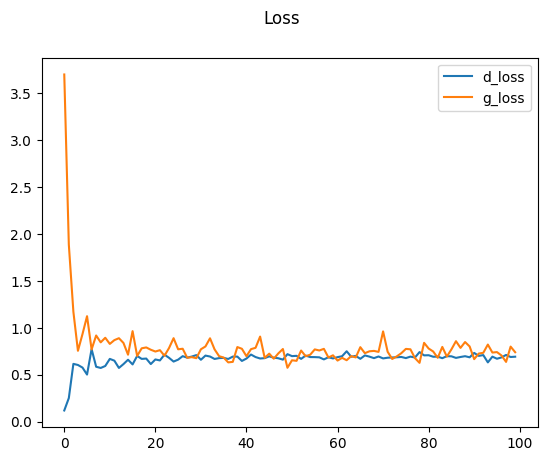

In [ ]:
plt.suptitle('Loss')
plt.plot(hist.history['d_loss'], label='d_loss')
plt.plot(hist.history['g_loss'], label='g_loss')
plt.legend()
plt.show()

4. Test Out the Generator

4.1 Generate Images

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


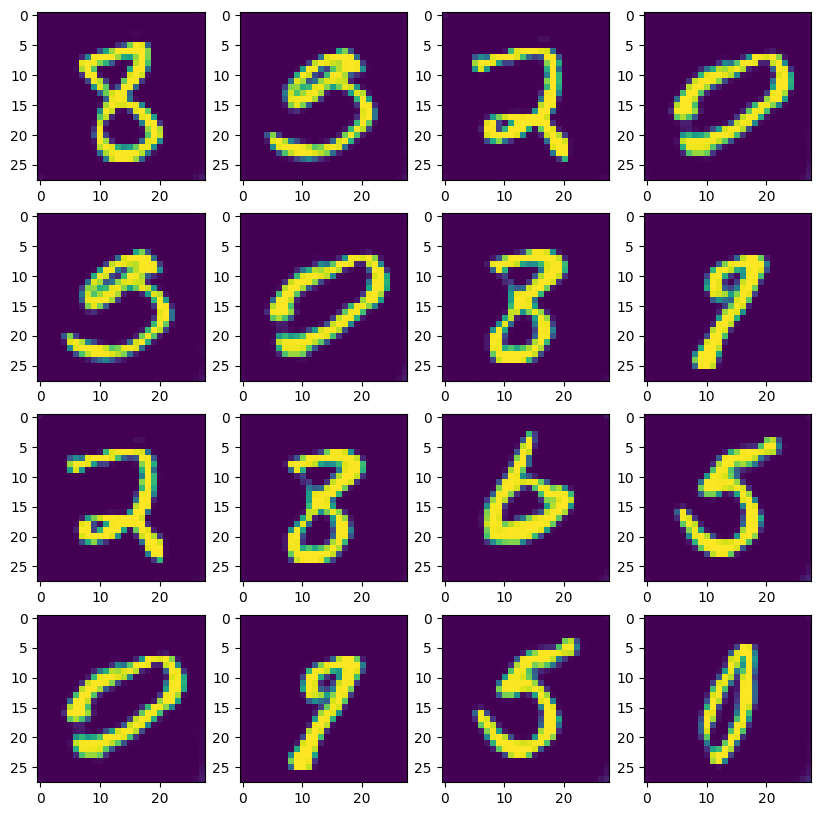

In [ ]:
#generator.load_weights('/content/drive/My Drive/generator.h5')
imgs = generator.predict(tf.random.normal((16, 100, 1)))
imgs[0]
fig, ax = plt.subplots(ncols=4, nrows=4, figsize=(10,10))
for r in range(4):
    for c in range(4):
        ax[r][c].imshow(imgs[(r+1)*(c+1)-1])